In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

trainset = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

testset = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle = True)


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw




Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw




Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw




Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [3]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Linear(784,256)
        self.conv2 = nn.Linear(256,128)
        self.conv3 = nn.Linear(128,64)
        self.conv4 = nn.Linear(64,10)

    def forward(self, x):
        x = x.view(x.shape[0], -1)

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.log_softmax(self.conv4(x), dim = 1)
        return x

In [5]:
model = Classifier()

images, labels = next(iter(testloader))
ps = torch.exp(model(images))
print (ps.shape)

torch.Size([64, 10])


In [6]:
model = Classifier()

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=.003)

epoch = 10
for e in range(epoch):
  running_loss = 0
  for images, labels in trainloader:
    #images = images.view(images.shape[0], -1)
    optimizer.zero_grad()

    output = model.forward(images)
    loss = criterion (output, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  
  else:
   # print('Epoch %3d: loss %.5f:' %(epoch+1, running_loss/len(trainloader)))
    print(f"Training loss: {running_loss}")

Training loss: 484.93708327412605
Training loss: 362.4416883662343
Training loss: 321.4044611379504
Training loss: 300.3186303898692
Training loss: 285.9511215314269
Training loss: 271.27057365328074
Training loss: 262.37619260698557
Training loss: 250.92353305965662
Training loss: 244.30900008231401
Training loss: 240.86376497149467


<Figure size 432x288 with 0 Axes>

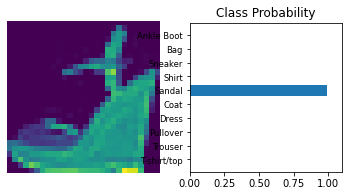

In [8]:
import helper

dataiter = iter(trainloader)
images, labels = dataiter.next()
img = images[1]

ps = torch.exp(model(img))

import matplotlib.pyplot as plt
import numpy as np

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

plt.tight_layout()

x = view_classify(img, ps, version="Fashion")


In [9]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.001)


epoch =20
steps = 0
train_losses = []
test_losses = []

for e in range(epoch):
  running_loss = 0
  for images, labels in trainloader:
    optimizer.zero_grad()

    log_ps = model(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  else:
    test_loss = 0
    accuracy = 0

    with torch.no_grad():
      model.eval()
      for images, labels in testloader:
        log_ps = model(images)
        test_loss += criterion(log_ps,labels)
        
        ps = torch.exp(model(images))
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()

    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))
    
   

    print("Epoch: {}/{}..".format(e+1, epoch), 
          "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
          "Test Loss: {:.3f}..".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader))     
    )
#    print(f'Accuracy: {accuracy.item()*100}% ')



Epoch: 1/20.. Training Loss: 0.547..  Test Loss: 0.413.. Test Accuracy: 0.853
Epoch: 2/20.. Training Loss: 0.376..  Test Loss: 0.387.. Test Accuracy: 0.862
Epoch: 3/20.. Training Loss: 0.337..  Test Loss: 0.415.. Test Accuracy: 0.853
Epoch: 4/20.. Training Loss: 0.316..  Test Loss: 0.346.. Test Accuracy: 0.877
Epoch: 5/20.. Training Loss: 0.296..  Test Loss: 0.348.. Test Accuracy: 0.874
Epoch: 6/20.. Training Loss: 0.280..  Test Loss: 0.339.. Test Accuracy: 0.881
Epoch: 7/20.. Training Loss: 0.265..  Test Loss: 0.342.. Test Accuracy: 0.882
Epoch: 8/20.. Training Loss: 0.255..  Test Loss: 0.323.. Test Accuracy: 0.886
Epoch: 9/20.. Training Loss: 0.242..  Test Loss: 0.332.. Test Accuracy: 0.885
Epoch: 10/20.. Training Loss: 0.233..  Test Loss: 0.326.. Test Accuracy: 0.888
Epoch: 11/20.. Training Loss: 0.224..  Test Loss: 0.327.. Test Accuracy: 0.890
Epoch: 12/20.. Training Loss: 0.218..  Test Loss: 0.329.. Test Accuracy: 0.885
Epoch: 13/20.. Training Loss: 0.208..  Test Loss: 0.341.. Tes

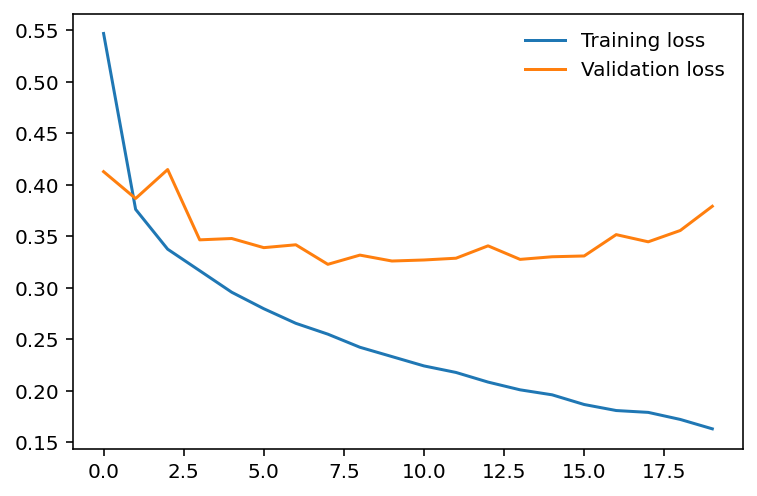

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)